In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# os.environ["
# _VISIBLE_DEVICES"] = "2"


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter

import numpy as np

from tqdm import tqdm
from tqdm import trange

# import math



# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
        
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_loss_inf = 0, 0


    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            test_loss_inf += torch.linalg.vector_norm(pred-y, ord = float('inf')).item()
    test_loss /= num_batches
    test_loss_inf /= num_batches


    return test_loss, test_loss_inf


In [ ]:
num_sample = 2000
num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

adjust_scale = 0

loss_fn = nn.MSELoss()

width_vector = [10, 20, 40, 80, 160, 320, 640, 1280]

width_vector_2 = [10, 20, 40, 80, 160, 320, 640, 1280]



times_w = 2

times_n = 1

k_period = 5

batch_size = 8

merge = 0

result_matrix = np.zeros((len(width_vector), 10))
result_matrix_infty = np.zeros((len(width_vector), 10))
result_matrix_pair = np.zeros((len(width_vector), 10))

result_matrix_adj = np.zeros((len(width_vector_2), 10))
result_matrix_infty_adj = np.zeros((len(width_vector_2), 10))
result_matrix_infty_pair = np.zeros((len(width_vector_2), 10))

In [ ]:
#generate test set
setup_seed(2022)
Coe = torch.rand(4)
print(Coe)

temp = torch.linspace(-1, 1, num_test)

# for consistency of tensor sizes
x_test = torch.unsqueeze(temp,1)

# # certain function expression: y = sin(\pi x)
y_test = - torch.sin(2 * torch.pi * x_test)


# create data loaders.
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = num_test, shuffle=False)

class NN(nn.Module):
    def __init__(self, layers):
        # First initial the __init__ in nn.Module 
        super(NN, self).__init__()

        self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
        self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)



    def forward(self, x):
        unacti = self.layer1(x)
        hidden1 = self.relu(unacti)
        hidden2 = self.layer2(hidden1)
        logits = self.layer3(hidden2)

        return logits

tensor([0.3958, 0.9219, 0.7588, 0.3811])


In [ ]:
i = 0

# for times_n in tqdm(para_vector):
for width in tqdm(width_vector):
    
    actual_width = times_w*width

        
    for j in range(10):
        
        
        model = NN([1, actual_width, 1, 1]).to(device)
        
        
        adjust_scale = 0

        model.load_state_dict(torch.load('./new_sin/trained_model/Sin-'+str(times_n)+'Xweight-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
        [result_matrix[i, j], result_matrix_infty[i, j]] = output_final(test_dataloader, model, loss_fn)
        

        model.load_state_dict(torch.load('./new_sin_TotalRan/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))


        [result_matrix_adj[i, j], result_matrix_infty_adj[i, j]] = output_final(test_dataloader, model, loss_fn)
        

        model.load_state_dict(torch.load('./new_sin_random/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

        [result_matrix_pair[i, j], result_matrix_infty_pair[i, j]] = output_final(test_dataloader, model, loss_fn)

        
    i += 1    
        
  

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


In [6]:
# for function plotting
width = 160
j = 2
adjust_scale = 0

model = NN([1, width*2, 1, 1]).to(device)


model.load_state_dict(torch.load('./new_sin/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
with torch.no_grad():
    
    X_test = x_test.to(device)
    Y_pred = model(X_test)

    y_pred = Y_pred.cpu().detach().numpy()

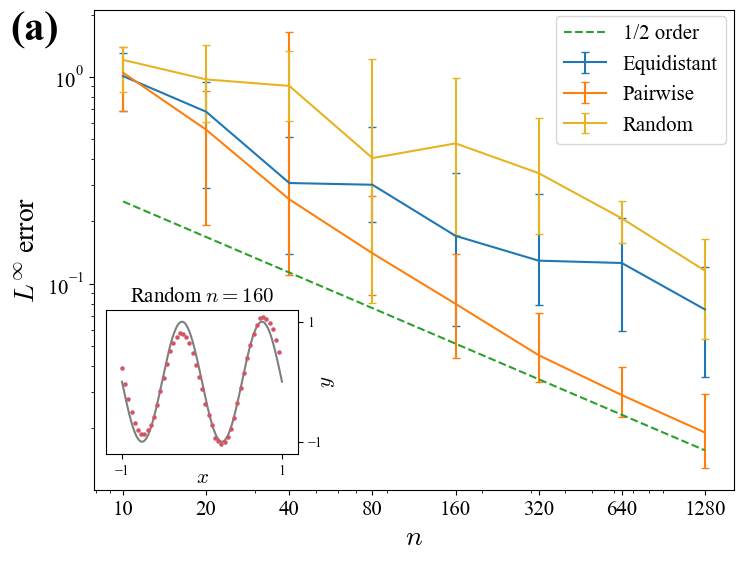

In [ ]:
from statistics import geometric_mean

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = width_vector


mean = np.zeros(int(len(x)))
mean_infty = np.zeros(int(len(x)))


for i in range(len(x)):
    mean[i] = geometric_mean(result_matrix[i])
    mean_infty[i] = geometric_mean(result_matrix_infty[i])


y_max = np.max(result_matrix, axis = 1)
y_min = np.min(result_matrix, axis = 1)

yerr = np.abs(np.vstack((y_min, y_max)) - mean)


y_max_infty = np.max(result_matrix_infty, axis = 1)
y_min_infty = np.min(result_matrix_infty, axis = 1)

yerr_infty = np.abs(np.vstack((y_min_infty, y_max_infty)) - mean_infty)



# totally random

x2 = width_vector_2

mean2 = np.zeros(int(len(x2)))
mean_infty2 = np.zeros(int(len(x2)))

for i in range(len(x2)):
    mean2[i] = geometric_mean(result_matrix_adj[i])
    mean_infty2[i] = geometric_mean(result_matrix_infty_adj[i])


y_max2 = np.max(result_matrix_adj, axis = 1)
y_min2 = np.min(result_matrix_adj, axis = 1)

yerr2 = np.abs(np.vstack((y_min2, y_max2)) - mean2)


y_max_infty2 = np.max(result_matrix_infty_adj, axis = 1)
y_min_infty2 = np.min(result_matrix_infty_adj, axis = 1)

yerr_infty2 = np.abs(np.vstack((y_min_infty2, y_max_infty2)) - mean_infty2)


# pairwise random

x3 = width_vector_2

mean3 = np.zeros(int(len(x2)))
mean_infty3 = np.zeros(int(len(x2)))

for i in range(len(x2)):
    mean3[i] = geometric_mean(result_matrix_pair[i])
    mean_infty3[i] = geometric_mean(result_matrix_infty_pair[i])


y_max3 = np.max(result_matrix_pair, axis = 1)
y_min3 = np.min(result_matrix_pair, axis = 1)

yerr3 = np.abs(np.vstack((y_min3, y_max3)) - mean3)


y_max_infty3 = np.max(result_matrix_infty_pair, axis = 1)
y_min_infty3 = np.min(result_matrix_infty_pair, axis = 1)

yerr_infty3 = np.abs(np.vstack((y_min_infty3, y_max_infty3)) - mean_infty3)



# for reference
begin_point = 2.5E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.sqrt(np.power(2,len(x)))]




fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])
plt.errorbar(x, mean_infty, yerr=yerr_infty, capsize = 3, label='Equidistant')

plt.errorbar(x3, mean_infty3, yerr=yerr_infty3, capsize = 3, label='Pairwise')

plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Random',  color = '#e6b422')


plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^\infty$ error', size=20)
plt.legend(fontsize=15, loc=(0.722, 0.721))
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)
X = ax1.get_position().x0
Y = ax1.get_position().y1 
fig.text(X - .105, Y - 0.05, '(a)', size=30, weight='bold')



l, b, w, h = 0.115, 0.16, 0.24, 0.24
ax2=fig.add_axes([l, b, w, h])
    
plt.plot(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), label='Data', linewidth = 1.5, color = '#7f7f7f', zorder = 1)
plt.scatter(x_test.cpu().detach().numpy()[::8], y_pred[::8], label='n', color = '#D25565', marker=".", s = 20, zorder = 2) 


ax2.yaxis.tick_right()
plt.xlabel('$x$', fontsize=15)
ax2.yaxis.set_label_position('right')
plt.ylabel('$y$', fontsize=15)
plt.title('Random $n = '+str(width)+'$', fontsize=15)
plt.xticks([-1, 1], fontsize=10)
plt.yticks([-1, 1], fontsize=10)

ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)

ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.yaxis.set_label_coords(1.1, 0.5)


plt.savefig('plot_sin.pdf', bbox_inches='tight')
plt.show()
